In [17]:
import numpy as np

import sys
import os
sys.path.append(os.path.join(os.path.dirname(os.getcwd())))


In [18]:
from sklearn.datasets import make_circles, make_moons, make_gaussian_quantiles
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# X, y = make_gaussian_quantiles(n_samples=300, n_features=2, n_classes=3, random_state=42)
X, y = make_circles(n_samples=300, noise=0.3, factor=0.2, random_state=42)
# X, y = make_moons(n_samples=500, noise=0.3, random_state=42)

# First split: 60% train, 40% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y
)

# Second split: 20% validation, 20% test (from the 40% temp)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# scaler = MinMaxScaler(feature_range=(-np.pi, np.pi))
# X_train = scaler.fit_transform(X_train)
# X_val = scaler.transform(X_val)
# X_test = scaler.transform(X_test)


print("Train set size:", X_train.shape)
print("Validation set size:", X_val.shape)
print("Test set size:", X_test.shape)


Train set size: (180, 2)
Validation set size: (60, 2)
Test set size: (60, 2)


In [19]:
np.savez_compressed(
    "../data/circle_data.npz",
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    X_test=X_test,
    y_test=y_test
)

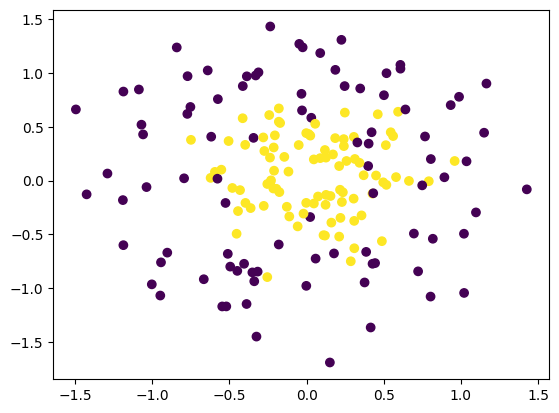

In [20]:
from matplotlib import pyplot as plt
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)
plt.show()

In [21]:
from sklearn.metrics.pairwise import rbf_kernel, polynomial_kernel, linear_kernel
from src.utils import calculate_accuracy, class_similarity, caculate_accuracy_train

rbf_K_train = rbf_kernel(X_train)
rbf_K_val = rbf_kernel(X_val, X_train)
rbf_K_test = rbf_kernel(X_test, X_train)

classical_val_acc, classical_test_acc, model = calculate_accuracy(rbf_K_train, rbf_K_val, rbf_K_test, y_train, y_val, y_test)
train_acc = caculate_accuracy_train(rbf_K_train, y_train)
print("Val acc | Test acc")
print(f"{classical_val_acc} | {classical_test_acc}")
print(f"Train acc: {train_acc}")

similarity = class_similarity(rbf_K_train, y_train)
print(similarity)

Val acc | Test acc
0.8333333333333334 | 0.9
Train acc: (0.8777777777777778, SVC(C=np.float64(1.001), kernel='precomputed'))
1.8247499103545934


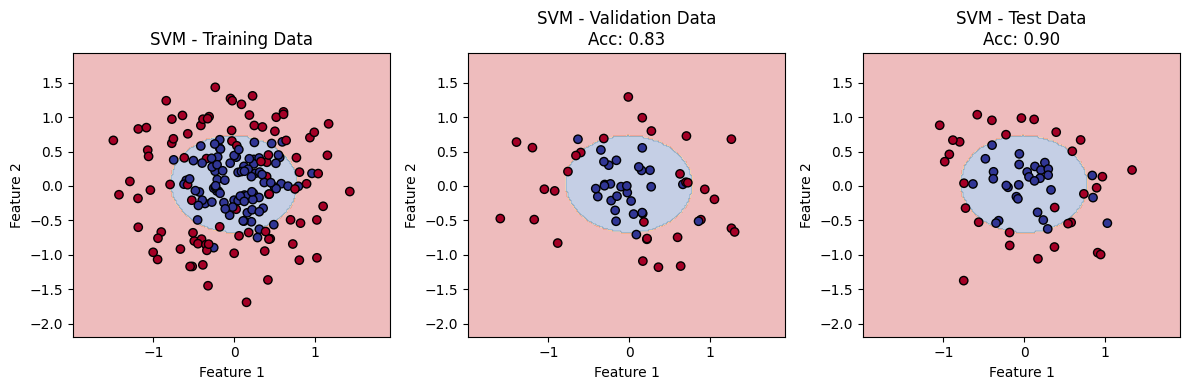

In [22]:
from sklearn.svm import SVC
from sklearn.metrics.pairwise import rbf_kernel, polynomial_kernel, linear_kernel
import matplotlib.pyplot as plt

# The model is already trained with precomputed kernel
svm = model

# Create mesh grid for decision boundary
h = 0.02  # step size in the mesh
x_min, x_max = X_train[:, 0].min() - 0.5, X_train[:, 0].max() + 0.5
y_min, y_max = X_train[:, 1].min() - 0.5, X_train[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# For precomputed kernel, we need to compute kernel between mesh points and training data
mesh_points = np.c_[xx.ravel(), yy.ravel()]
K_mesh = rbf_kernel(mesh_points, X_train)  # Kernel between mesh and training data

# Predict on mesh grid using the precomputed kernel
Z = svm.predict(K_mesh)
Z = Z.reshape(xx.shape)

# Plot
plt.figure(figsize=(12, 4))

# Training data
plt.subplot(1, 3, 1)
plt.contourf(xx, yy, Z, alpha=0.3, cmap='RdYlBu')
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='RdYlBu', edgecolors='k')
plt.title(f'SVM - Training Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

# Validation data
plt.subplot(1, 3, 2)
plt.contourf(xx, yy, Z, alpha=0.3, cmap='RdYlBu')
plt.scatter(X_val[:, 0], X_val[:, 1], c=y_val, cmap='RdYlBu', edgecolors='k')
plt.title(f'SVM - Validation Data\nAcc: {classical_val_acc:.2f}')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

# Test data
plt.subplot(1, 3, 3)
plt.contourf(xx, yy, Z, alpha=0.3, cmap='RdYlBu')
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='RdYlBu', edgecolors='k')
plt.title(f'SVM - Test Data\nAcc: {classical_test_acc:.2f}')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.tight_layout()
plt.show()

In [23]:
from src.feature_map import TrainableQuantumFeatureMap as TQFM2
from src.kernel_estimate import KernelMatrix
from qiskit_algorithms.optimizers import COBYLA, SPSA, ADAM
import time



# Create optimizer instance based on argument
maxiter = 10000
optimizer_map = {
	"COBYLA": COBYLA(maxiter=maxiter),
	"SPSA": SPSA(maxiter=maxiter),
	"ADAM": ADAM(maxiter=maxiter, tol= 0.001, lr= 0.1)
}

optimizer = optimizer_map["COBYLA"]

tqfm = TQFM2(depth=1, type_ansatz="RealAmplitudes")

# Train TQFM
start_time = time.time()
tqfm.fit(X_train, y_train, optimizer=optimizer)
training_time = time.time() - start_time

print(f"Optimal value: {tqfm.optimal_value}")
print(f" Training completed in {training_time:.2f} seconds ({training_time/60:.2f} minutes)")


# Compute kernel matrices
kernel_train_before = KernelMatrix.compute_kernel_matrix_with_inner_products(X_train, X_train, tqfm.init_theta, tqfm.circuit)
kernel_train_after = KernelMatrix.compute_kernel_matrix_with_inner_products(X_train, X_train, tqfm.optimal_params, tqfm.circuit)
kernel_val = KernelMatrix.compute_kernel_matrix_with_inner_products(X_val, X_train, tqfm.optimal_params, tqfm.circuit)
kernel_test = KernelMatrix.compute_kernel_matrix_with_inner_products(X_test, X_train, tqfm.optimal_params, tqfm.circuit)


Number of qubits: 2, Number of classes: 2
Optimal value: 0.36105942580859063
 Training completed in 288.35 seconds (4.81 minutes)
Optimal value: 0.36105942580859063
 Training completed in 288.35 seconds (4.81 minutes)


In [24]:
from src.utils import calculate_accuracy, class_similarity, caculate_accuracy_train
val_acc_before, test_acc_before, _ = calculate_accuracy(kernel_train_before, kernel_val, kernel_test, y_train, y_val, y_test)
val_acc_after, test_acc_after, _ = calculate_accuracy(kernel_train_after, kernel_val, kernel_test, y_train, y_val, y_test)
similarity_before = class_similarity(kernel_train_before, y_train)
similarity_after = class_similarity(kernel_train_after, y_train)

train_acc_before, _ = caculate_accuracy_train(kernel_train_before, y_train)
train_acc_after, model = caculate_accuracy_train(kernel_train_after, y_train)



print(f"Train Accuracy after TQFM training: {train_acc_after:.4f}")


Train Accuracy after TQFM training: 0.8333


Text(0.5, 1.0, 'TQFM Training Loss History')

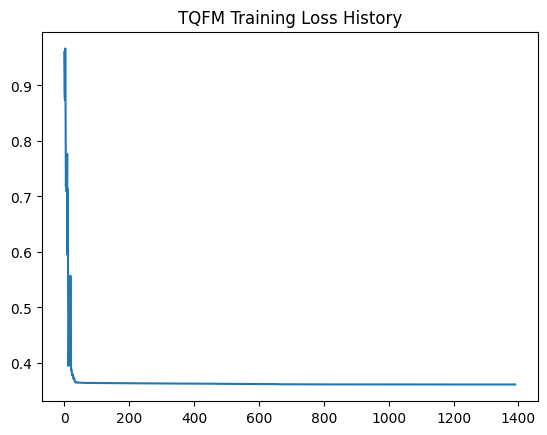

In [25]:
plt.plot(tqfm.loss_history)
plt.title("TQFM Training Loss History")

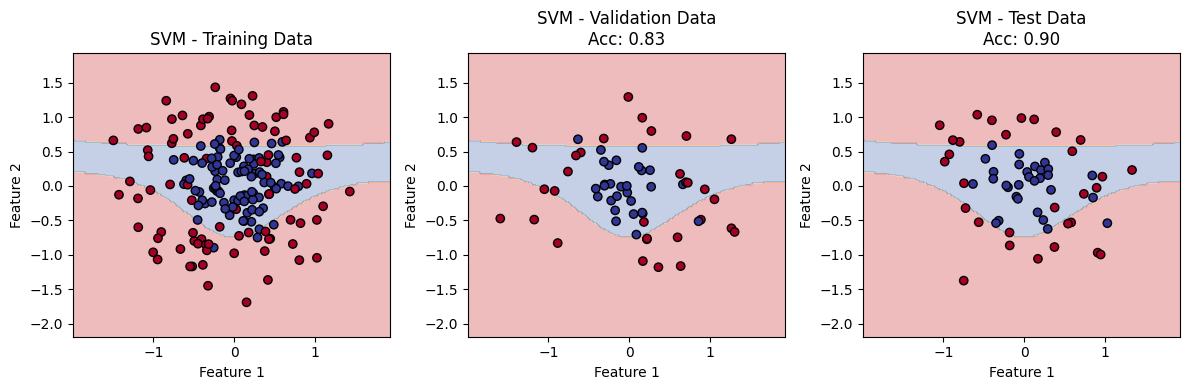

In [26]:
from sklearn.svm import SVC
import matplotlib.pyplot as plt

# The model is already trained with precomputed kernel
svm = model

# Create mesh grid for decision boundary
h = 0.02  # step size in the mesh
x_min, x_max = X_train[:, 0].min() - 0.5, X_train[:, 0].max() + 0.5
y_min, y_max = X_train[:, 1].min() - 0.5, X_train[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# For precomputed kernel, we need to compute kernel between mesh points and training data
mesh_points = np.c_[xx.ravel(), yy.ravel()]
K_mesh = KernelMatrix.compute_kernel_matrix_with_inner_products(mesh_points, X_train, tqfm.optimal_params, tqfm.circuit)

# Predict on mesh grid using the precomputed kernel
Z = svm.predict(K_mesh)
Z = Z.reshape(xx.shape)

# Plot
plt.figure(figsize=(12, 4))

# Training data
plt.subplot(1, 3, 1)
plt.contourf(xx, yy, Z, alpha=0.3, cmap='RdYlBu')
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='RdYlBu', edgecolors='k')
plt.title(f'SVM - Training Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

# Validation data
plt.subplot(1, 3, 2)
plt.contourf(xx, yy, Z, alpha=0.3, cmap='RdYlBu')
plt.scatter(X_val[:, 0], X_val[:, 1], c=y_val, cmap='RdYlBu', edgecolors='k')
plt.title(f'SVM - Validation Data\nAcc: {classical_val_acc:.2f}')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

# Test data
plt.subplot(1, 3, 3)
plt.contourf(xx, yy, Z, alpha=0.3, cmap='RdYlBu')
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='RdYlBu', edgecolors='k')
plt.title(f'SVM - Test Data\nAcc: {classical_test_acc:.2f}')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.tight_layout()
plt.show()